In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

#플롯에서 한글이 깨지는 경우가 없도록 폰트 지정
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [55]:
scaler = MinMaxScaler()

#인구예측지수
df_linear = pd.read_csv('단순회귀_BayesianRidge기반_청년지수.csv', encoding='cp949')

df_linear = df_linear.drop('Unnamed: 0',axis=1)
df_linear.set_index('시군구', inplace=True)

#인프라 기준 청년밀집도
df_pycrat = pd.read_csv('단순회귀_BayesianRidge기반_청년지수(인구_지수).csv', encoding='cp949')

df_pycrat = df_pycrat.drop('Unnamed: 0',axis=1)
df_pycrat.set_index('시군구', inplace=True)



#시군구 위경도 데이터 불러오기
df_loc = pd.read_csv('시군구_위경도.csv', encoding='cp949')
df_loc = df_loc.drop(['Unnamed: 4'], axis = 1) #비어있는 열 제거 

df_loc = df_loc.loc[0:74] #세종까지 행을 자름
df_loc = df_loc.set_index('name') # 인덱스를 시군구로 지정

#위경도를 붙어줌
df_linear_loc_merge = df_linear.join(df_loc, how='left')

df_pycrat_loc_merge = df_pycrat.join(df_loc, how='left')

df_linear_loc_merge

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_종로구,32943.0,496,28.0,3,60.0,0,1,23,5730,24,201,0,19.0,0.0,367.0,0.0,33.647847,11110.0,37.594920,126.977317
서울_중구,28277.0,572,16.0,2,48.0,0,1,17,5383,62,281,1,18.0,0.0,77.0,0.0,32.067071,11140.0,37.560143,126.995968
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,29.072168,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,27.370827,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,33.649486,11215.0,37.546722,127.085746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,43.607093,31140.0,35.516052,129.328190
울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,17.712287,31170.0,35.525580,129.426070
울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,19.817415,31200.0,35.610062,129.379802


## 이상치 데이터 처리

In [56]:
def get_outlier(df, column, weight=1.5):
    # 이상치가 있는 index 반환
    
    # 1/4분위와 3/4분위 지점 지정
    quantile_25 = np.percentile(df[column].values, 25) #Q1
    quantile_75 = np.percentile(df[column].values, 75) #Q3
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고, index 반환
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    
    return outlier_idx
#linear 데이터
outlier_linear_idx1 = get_outlier(df_linear_loc_merge, '병원')
print("이상치 데이터 index1: ", outlier_linear_idx1)

outlier_linear_idx2 = get_outlier(df_linear_loc_merge, '사회스포츠')
print("이상치 데이터 index2: ", outlier_linear_idx2)

outlier_linear_idx3 = get_outlier(df_linear_loc_merge, '경찰서')
print("이상치 데이터 index3: ", outlier_linear_idx3)

outlier_linear_idx4 = get_outlier(df_linear_loc_merge, '소형상업시설(음식점_카페_학원_편의점)')
print("이상치 데이터 index4: ", outlier_linear_idx4)

outlier_linear_idx5 = get_outlier(df_linear_loc_merge, '대형상업시설')
print("이상치 데이터 index5: ", outlier_linear_idx5)

#pycrat 데이터
outlier_pycrat_idx1 = get_outlier(df_pycrat_loc_merge, '병원')
print("이상치 데이터 index1: ", outlier_pycrat_idx1)

outlier_pycrat_idx2 = get_outlier(df_pycrat_loc_merge, '사회스포츠')
print("이상치 데이터 index2: ", outlier_pycrat_idx2)

outlier_pycrat_idx3 = get_outlier(df_pycrat_loc_merge, '경찰서')
print("이상치 데이터 index3: ", outlier_pycrat_idx3)

outlier_pycrat_idx4 = get_outlier(df_pycrat_loc_merge, '소형상업시설(음식점_카페_학원_편의점)')
print("이상치 데이터 index4: ", outlier_pycrat_idx4)

outlier_pycrat_idx5 = get_outlier(df_pycrat_loc_merge, '대형상업시설')
print("이상치 데이터 index5: ", outlier_pycrat_idx5)

이상치 데이터 index1:  Index(['서울_서초구', '서울_강남구', '서울_송파구'], dtype='object', name='시군구')
이상치 데이터 index2:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index3:  Index(['서울_종로구'], dtype='object', name='시군구')
이상치 데이터 index4:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index5:  Index(['서울_중구'], dtype='object', name='시군구')
이상치 데이터 index1:  Index(['서울_서초구', '서울_강남구', '서울_송파구'], dtype='object', name='시군구')
이상치 데이터 index2:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index3:  Index(['서울_종로구'], dtype='object', name='시군구')
이상치 데이터 index4:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index5:  Index(['서울_중구'], dtype='object', name='시군구')


In [72]:
df_linear_copy = df_linear_loc_merge.copy()

df_linear_copy.drop(outlier_linear_idx1, axis=0, inplace=True)
df_linear_copy.drop(outlier_linear_idx3, axis=0, inplace=True)
df_linear_copy.drop(outlier_linear_idx5, axis=0, inplace=True)

df_pycrat_copy = df_pycrat_loc_merge.copy()

df_pycrat_copy.drop(outlier_pycrat_idx1, axis=0, inplace=True)
df_pycrat_copy.drop(outlier_pycrat_idx3, axis=0, inplace=True)
df_pycrat_copy.drop(outlier_pycrat_idx5, axis=0, inplace=True)

df_linear_copy.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,29.072168,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,27.370827,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,33.649486,11215.0,37.546722,127.085746
서울_동대문구,80217.0,597,43.0,4,76.0,0,1,12,4902,33,112,7,16.0,0.0,21.0,0.0,29.981807,11230.0,37.581957,127.054848
서울_중랑구,83722.0,539,96.0,1,76.0,0,1,9,4410,14,89,7,18.0,0.0,5.0,1.0,27.005736,11260.0,37.597819,127.092884


In [58]:
#df_linear_copy.to_csv("인구예측지수.csv", encoding = 'cp949')
#df_pycrat_copy.to_csv("인프라 기준 청년밀집도.csv", encoding = 'cp949')

In [75]:
df_linear_col = df_linear_copy[['청년인프라지수','lat','lon']] #정규화 진행전 빼놓기
df_linear_copy = df_linear_copy.drop(['청년인프라지수','id','lat','lon'], axis=1)

#정규화 진행
df_linear_copy[:] = scaler.fit_transform(df_linear_copy[:])
df_linear_copy.head()

df_pycrat_col = df_pycrat_copy[['청년인프라지수','lat','lon']] #정규화 진행전 빼놓기
df_pycrat_copy = df_pycrat_copy.drop(['청년인프라지수','id','lat','lon'], axis=1)

#정규화 진행
df_pycrat_copy[:] = scaler.fit_transform(df_pycrat_copy[:])
df_pycrat_copy.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널
시군구,,,,,,,,,,,,,,,,
서울_용산구,0.318906,0.335253,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.498214,0.403509,0.275316,1.000000,0.478261,0.25,0.618421,0.00
서울_성동구,0.414634,0.494240,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.441282,0.385965,0.142405,0.333333,0.521739,0.00,0.394737,0.00
서울_광진구,0.569801,0.610599,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.561945,0.456140,0.155063,0.000000,0.434783,0.00,0.315789,0.25
서울_동대문구,0.498842,0.655530,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.480466,0.578947,0.300633,0.777778,0.391304,0.00,0.263158,0.00
서울_중랑구,0.521641,0.588710,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.423764,0.245614,0.227848,0.777778,0.478261,0.00,0.052632,0.25


In [76]:
#정규화 후 위경도,인프라지수 합쳐주기
df_linear_copy = df_linear_copy.join(df_linear_col, how = 'left')

df_pycrat_copy = df_pycrat_copy.join(df_pycrat_col, how = 'left')
df_pycrat_copy.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,lat,lon
시군구,,,,,,,,,,,,,,,,,,,
서울_용산구,0.318906,0.335253,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.498214,0.403509,0.275316,1.000000,0.478261,0.25,0.618421,0.00,4.338500,37.531386,126.979908
서울_성동구,0.414634,0.494240,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.441282,0.385965,0.142405,0.333333,0.521739,0.00,0.394737,0.00,5.898631,37.551030,127.041059
서울_광진구,0.569801,0.610599,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.561945,0.456140,0.155063,0.000000,0.434783,0.00,0.315789,0.25,6.499428,37.546722,127.085746
서울_동대문구,0.498842,0.655530,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.480466,0.578947,0.300633,0.777778,0.391304,0.00,0.263158,0.00,6.421254,37.581957,127.054848
서울_중랑구,0.521641,0.588710,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.423764,0.245614,0.227848,0.777778,0.478261,0.00,0.052632,0.25,7.440375,37.597819,127.092884


## 클러스터 결정

C:\Users\csh51\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


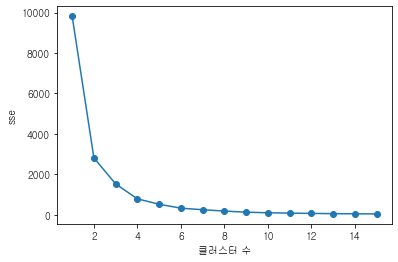

In [79]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

x_linear = df_linear_copy[['청년인구','소형상업시설(음식점_카페_학원_편의점)','병원','경찰서','숙박시설','법원, 교도소','청년인프라지수']].values

x_pycrat = df_pycrat_copy[['청년인구','소형상업시설(음식점_카페_학원_편의점)','병원','경찰서','숙박시설','법원, 교도소','청년인프라지수']].values

## 방법 elbow기법

from sklearn.cluster import KMeans
init_centroid = "random" # 초기 클러스터 중심을 임의적
#init_centroid = "k-means++" # 기본값

def elbow(x):
    sse = [] #오차제곱합이 최소가 되도록 클러스터의 중심을 결정
    for i in range(1, 16):
        km = KMeans(n_clusters = i, init = "k-means++", random_state = 0)
        km.fit(x)
        sse.append(km.inertia_)
    plt.plot(range(1, 16), sse, marker = "o")
    plt.xlabel("클러스터 수")
    plt.ylabel("sse")
    plt.show()
    
elbow(x_linear)

# k=4로실시

C:\Users\csh51\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


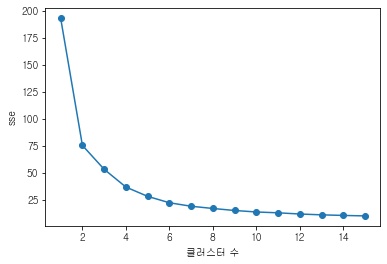

In [80]:
elbow(x_pycrat)

# k=4로실시

In [81]:
kmodel = KMeans(n_clusters = 2, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x_pycrat)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2'])
center.columns =['청년인구','소형상업시설(음식점_카페_학원_편의점)','병원','경찰서','숙박시설','법원, 교도소','청년인프라지수']

center

KMeans(init='random', n_clusters=2, random_state=0)
pred:  [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,청년인구,소형상업시설(음식점_카페_학원_편의점),병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
군집1,0.283898,0.463289,0.407655,0.398148,0.322785,0.172222,3.884338
군집2,0.535011,0.513675,0.602903,0.520000,0.189367,0.070000,6.564083


In [91]:
import folium as g

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_pycrat_copy)):
    if pred[i]==0: 
        point = 'red'
    elif pred[i]== 1:
        point='blue'
    
    marker = g.Marker([df_pycrat_copy['lat'][i], df_pycrat_copy['lon'][i]], #위경도
                    tooltip = (df_pycrat_copy.index[i],
                               center.index[pred[i]], 
                               df_pycrat_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

In [114]:
kmodel = KMeans(n_clusters = 3, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x_pycrat)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3'])
center.columns =['청년인구','소형상업시설(음식점_카페_학원_편의점)','병원','경찰서','숙박시설','법원, 교도소','청년인프라지수']


center

KMeans(init='random', n_clusters=3, random_state=0)
pred:  [1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 0 1 0 0 1 1 1 2 1 1 1 0 1 1 1 0 0
 1 0 1 1 1 1 1 0 1 2 2 1 2 2 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1]


,청년인구,소형상업시설(음식점_카페_학원_편의점),병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
군집1,0.107916,0.252844,0.173609,0.346154,0.416018,0.115385,2.858734
군집2,0.360364,0.547363,0.504608,0.424020,0.279691,0.191176,4.367912
군집3,0.543277,0.512720,0.608846,0.521739,0.188773,0.065217,6.661945


In [115]:
import folium as g

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_pycrat_copy)):
    if pred[i]==0: 
        point = 'red'
    elif pred[i]== 1:
        point='darkblue'
    elif pred[i]== 2:
        point='lightgreen'

    
    marker = g.Marker([df_pycrat_copy['lat'][i], df_pycrat_copy['lon'][i]], #위경도
                    tooltip = (df_pycrat_copy.index[i],
                               center.index[pred[i]], 
                               df_pycrat_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map



In [116]:
Map.save('인프라지수 K-means 군집분석 지도.html')

In [87]:
kmodel = KMeans(n_clusters = 4, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x_pycrat)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3','군집4'])
center.columns =['청년인구','소형상업시설(음식점_카페_학원_편의점)','병원','경찰서','숙박시설','법원, 교도소','청년인프라지수']


center


KMeans(init='random', n_clusters=4, random_state=0)
pred:  [0 2 2 2 1 1 2 1 1 1 2 0 1 1 2 2 2 1 1 2 3 0 3 3 0 0 0 2 0 0 0 3 0 0 2 3 3
 0 3 0 0 0 0 0 3 0 2 2 2 2 2 2 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0]


,청년인구,소형상업시설(음식점_카페_학원_편의점),병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
군집1,0.347678,0.541759,0.490486,0.411290,0.277971,0.201613,4.274488
군집2,0.637935,0.517396,0.699565,0.564815,0.130450,0.055556,7.588649
군집3,0.484019,0.526578,0.568176,0.504902,0.238831,0.073529,5.936870
군집4,0.107916,0.252844,0.173609,0.346154,0.416018,0.115385,2.858734


In [93]:
import folium as g

Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_pycrat_copy)):
    if pred[i]==0: 
        point = 'red'
    elif pred[i]== 1:
        point='blue'
    elif pred[i]== 2:
        point='darkblue'
    elif pred[i]== 3:
        point='lightgreen'
    
    marker = g.Marker([df_pycrat_copy['lat'][i], df_pycrat_copy['lon'][i]], #위경도
                    tooltip = (df_pycrat_copy.index[i],
                               center.index[pred[i]], 
                               df_pycrat_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map


## 계층적 군집분석

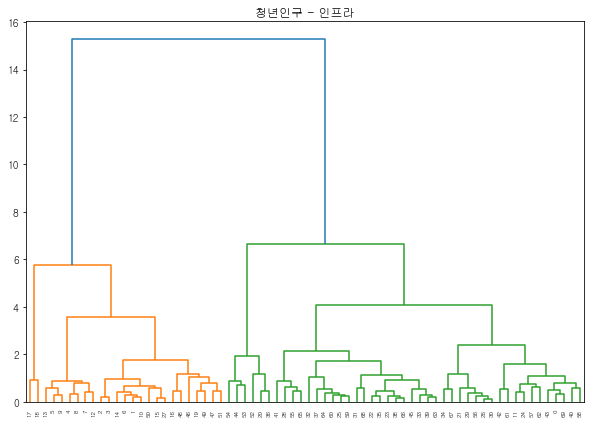

In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage #계층적 군집분석시 필요
from matplotlib import pyplot as plt

df_Den = df_pycrat_copy.reindex(columns=['청년인구','소형상업시설(음식점_카페_학원_편의점)','병원','경찰서','숙박시설','법원, 교도소','청년인프라지수'])

linked = linkage(df_Den, 'single')

labelList = df_pycrat_copy.index


import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("청년인구 - 인프라")
dend = shc.dendrogram(shc.linkage(df_Den, method='ward'))

In [97]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()

center = pd.DataFrame([arr1,arr2],
                     index = ['군집1','군집2'])

center


,청년인구,소형상업시설(음식점_카페_학원_편의점),병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
군집1,0.276019,0.452192,0.393446,0.388889,0.317159,0.177778,3.891803
군집2,0.549194,0.533650,0.628479,0.536667,0.199494,0.060000,6.550646


In [98]:
Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_pycrat_copy)):
    if df_pred[i]==0:
        point = 'red'
    elif df_pred[i]== 1:
        point='darkblue'
    
    marker = g.Marker([df_pycrat_copy['lat'][i], df_pycrat_copy['lon'][i]], #위경도
                    tooltip = (df_pycrat_copy.index[i],
                               center.index[df_pred[i]], 
                               df_pycrat_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

In [118]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()

center = pd.DataFrame([arr1,arr2,arr3],
                     index = ['군집1','군집2','군집3'])

center

,청년인구,소형상업시설(음식점_카페_학원_편의점),병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
군집1,0.549194,0.533650,0.628479,0.536667,0.199494,0.060000,6.550646
군집2,0.307699,0.485640,0.427272,0.393162,0.272152,0.185897,4.156937
군집3,0.070098,0.234778,0.173579,0.361111,0.609705,0.125000,2.168429


In [119]:
Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_pycrat_copy)):
    if df_pred[i]==0:
        point = 'lightgreen'
    elif df_pred[i]== 1:
        point='darkblue'
    elif df_pred[i]== 2:
        point='red'
    
    marker = g.Marker([df_pycrat_copy['lat'][i], df_pycrat_copy['lon'][i]], #위경도
                    tooltip = (df_pycrat_copy.index[i],
                               center.index[df_pred[i]], 
                               df_pycrat_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

In [120]:
Map.save('인프라지수 계층적 군집분석 지도.html')

In [104]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()
arr4 = df_Den[df_pred == 3].mean()

center = pd.DataFrame([arr1,arr2,arr3,arr4],
                     index = ['군집1','군집2','군집3','군집4'])

center


,청년인구,소형상업시설(음식점_카페_학원_편의점),병원,경찰서,숙박시설,"법원, 교도소",청년인프라지수
군집1,0.307699,0.485640,0.427272,0.393162,0.272152,0.185897,4.156937
군집2,0.526985,0.534266,0.620467,0.539855,0.203908,0.065217,6.311761
군집3,0.070098,0.234778,0.173579,0.361111,0.609705,0.125000,2.168429
군집4,0.804593,0.526564,0.720622,0.500000,0.148734,0.000000,9.297827


In [105]:
Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy)):
    if df_pred[i]==0:
        point = 'red'
    elif df_pred[i]== 1:
        point='darkblue'
    elif df_pred[i]== 2:
        point='blue'
    elif df_pred[i]== 3:
        point='lightgreen'
    
    marker = g.Marker([df_copy['lat'][i], df_copy['lon'][i]], #위경도
                    tooltip = (df_copy.index[i],
                               center.index[df_pred[i]], 
                               df_copy['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map
